# Build and Train a Classifier for Car Detection in Images

In this section the classifier is designed that will later be used to detect cars in a video stream. In the next section the training of the classifier is addressed.

In [1]:
# import packages that are required for computations in this notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
from scipy.ndimage.measurements import label
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
%matplotlib inline

For the training of the classifier, the vehicle and non-vehicle images of the git repository training_datasets will be used. The file paths to the images are first loaded with glob and stored in the lists cars[] and nocars[] respectively.

In [2]:
cars = glob.glob('./training_datasets/vehicles/*/*/*.png', recursive=True)
nocars = glob.glob('./training_datasets/non_vehicles/*/*/*.png', recursive=True)
print(len(cars))
print(len(nocars))

8792
8968


In the following the 'RGB' representation of a randomly selected car image will be transformed into different color spaces and the pixel values of the test image will be shown in 3d plots for each colorspace.

In [3]:
def plot3d(imglist, colors_rgb,
        csplist, axis_limits=[(0, 255), (0, 255), (0, 255)]):

    # Create figure and 3D axes
    fig = plt.figure(figsize=(15, 10))
    for i in range(len(imglist)):
        pixels = imglist[i]
        axis_labels = list(csplist[i])
        
        ax = fig.add_subplot(2,3,i+1,projection='3d')

        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=8, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=8, labelpad=8)
        ax.set_ylabel(axis_labels[1], fontsize=8, labelpad=8)
        ax.set_zlabel(axis_labels[2], fontsize=8, labelpad=8)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    plt.show()

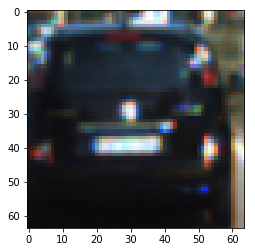

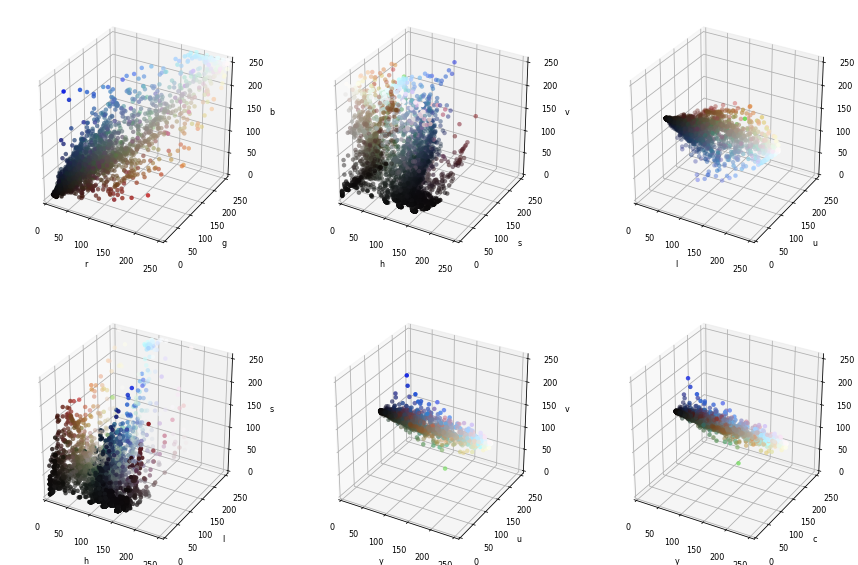

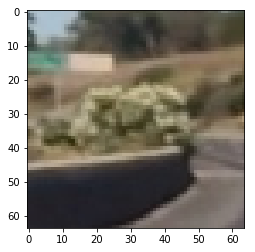

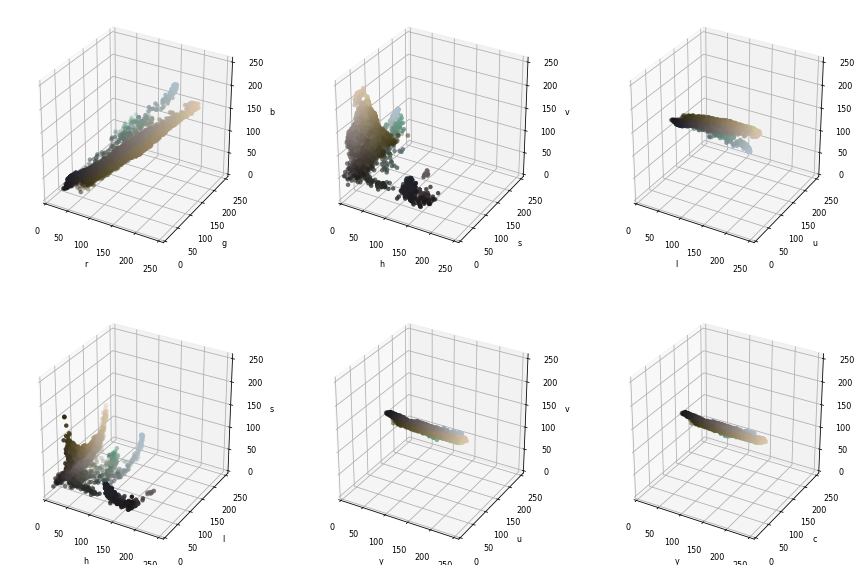

In [4]:
sel = np.random.randint(0,len(cars))
img = cv2.cvtColor(cv2.imread(cars[sel]),cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_NEAREST)
plt.imshow(img)
img_rgb = np.copy(img)
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
img_rgbc = img_rgb / 255.

img_list = [img_rgb,img_hsv,img_luv,img_hls,img_yuv,img_ycrcb]
csp_list = ['rgb','hsv','luv','hls','yuv','ycrcb']
plot3d(img_list,img_rgbc,csp_list)

img_nc = cv2.cvtColor(cv2.imread(nocars[sel]),cv2.COLOR_BGR2RGB)
img_nc = cv2.resize(img_nc, dsize=(64,64), interpolation=cv2.INTER_NEAREST)
plt.imshow(img_nc)
img_rgb = np.copy(img_nc)
img_hsv = cv2.cvtColor(img_nc, cv2.COLOR_RGB2HSV)
img_luv = cv2.cvtColor(img_nc, cv2.COLOR_RGB2LUV)
img_hls = cv2.cvtColor(img_nc, cv2.COLOR_RGB2HLS)
img_yuv = cv2.cvtColor(img_nc, cv2.COLOR_RGB2YUV)
img_ycrcb = cv2.cvtColor(img_nc, cv2.COLOR_RGB2YCrCb)
img_rgbc = img_rgb / 255.

img_list = [img_rgb,img_hsv,img_luv,img_hls,img_yuv,img_ycrcb]
plot3d(img_list,img_rgbc,csp_list)

=> Especially the 'HLS' and 'HSV' colorspaces show a nice separation of car pixels and background so that a transformation into these colorspaces might be able to help the classification.

In the following section the functions for feature extraction from a test image are defined. These are:

* color histograms
* spatial color binning
* and hog features

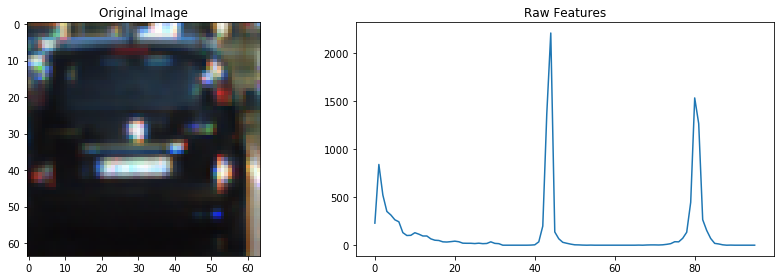

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# print (HLS) color histogram for test image
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(color_hist(f_img))
plt.title('Raw Features')
fig.tight_layout()

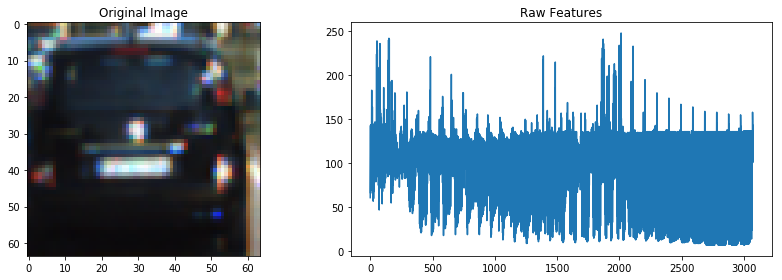

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# print (HLS) spatial binning for same test image as above
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(bin_spatial(f_img))
plt.title('Raw Features')
fig.tight_layout()

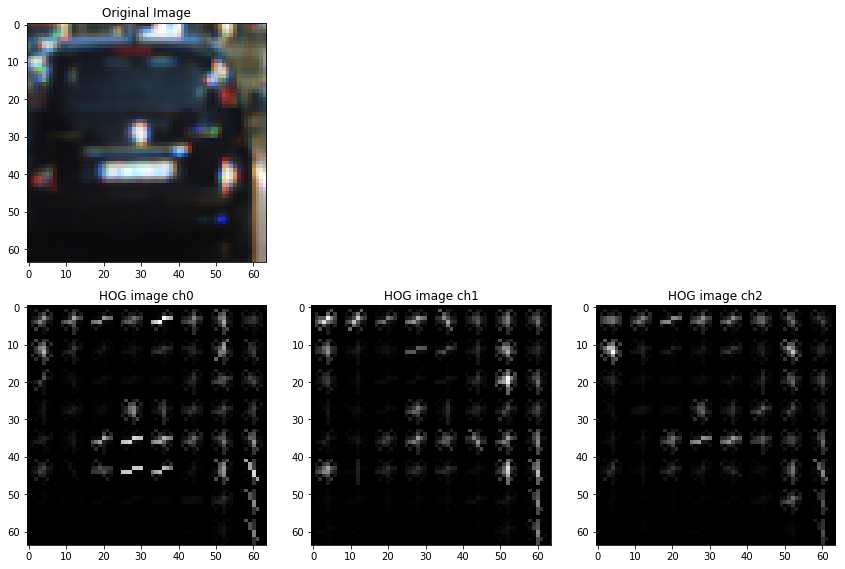

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features
    
# print hog features for grayscale version of same test image as above
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
hog_features0,hog_image0 = get_hog_features(f_img[:,:,0],vis=True)
hog_features1,hog_image1 = get_hog_features(f_img[:,:,1],vis=True)
hog_features2,hog_image2 = get_hog_features(f_img[:,:,2],vis=True)
fig = plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(234)
plt.imshow(hog_image0,cmap='gray')
plt.title('HOG image ch0')
plt.subplot(235)
plt.imshow(hog_image1,cmap='gray')
plt.title('HOG image ch1')
plt.subplot(236)
plt.imshow(hog_image2,cmap='gray')
plt.title('HOG image ch2')
fig.tight_layout()

Next, the functions defined above are called from the function extract_features. The output of this function is a concatenated feature array that will be used for classification of images and/or video streams.

In [8]:
def extract_features(img, cspace='LUV', hist_bins=32, hist_range=(0, 256),
                                          spatial_size=(32, 32),
                                          orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                          hist_feat=True, spatial_feat=True, hog_feat=True):
    features = []
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    features_colhist=[]
    features_spatial=[]
    features_hog=[]
    if(hist_feat==True):
        features_colhist = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
    if(spatial_feat==True):
        features_spatial = bin_spatial(feature_image,size=spatial_size)
    if(hog_feat==True):
        if hog_channel == 'ALL':
            features_hog=[]
            for channel in range(feature_image.shape[2]):
                ch_feats = get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=False).ravel()
                features_hog.append(ch_feats)
            features_hog = np.hstack(features_hog)
        else:
            features_hog = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
    features = np.concatenate((features_spatial,features_colhist,features_hog))
    return features

The functions are now applied and with the extracted features the classifier is trained:

In [9]:
# extract features from images:
car_features   = []
nocar_features = []
for car in cars:
    img = cv2.cvtColor(cv2.imread(car),cv2.COLOR_BGR2RGB)
    car_features.append(extract_features(img, cspace='LUV', hog_channel=0))

for nocar in nocars:
    img = cv2.cvtColor(cv2.imread(nocar),cv2.COLOR_BGR2RGB)
    nocar_features.append(extract_features(img, cspace='LUV', hog_channel=0))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, nocar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
else:
    print('function only returns empty feature vectors...')
        
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))

In [10]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [11]:
#parameters = {'C':[1, 10]}
clf = LinearSVC()
#clf = GridSearchCV(svr, parameters) 
#print(clf.best_params_)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

11.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9803
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
0.00116 Seconds to predict 10 labels with SVC


In [12]:
import pickle
svc_dict = {'svc': clf, 'scaler': X_scaler}
pickle.dump(svc_dict,open('./svc_data.p','wb'))

# Detect cars in images by sliding window search

In [13]:
svc_file = './svc_data.p'

with open(svc_file, mode='rb') as f:
    svc_dict = pickle.load(f)
    
clf, X_scaler = svc_dict['svc'], svc_dict['scaler']

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
def search_windows(img, windows, clf, scaler, color_space='LUV', 
                   hist_bins=32, hist_range=(0, 256),
                   spatial_size=(32, 32),
                   orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   hist_feat=True, spatial_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=color_space, 
                                    hist_bins=hist_bins, hist_range=hist_range,
                                    spatial_size=spatial_size,  
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    hist_feat=hist_feat, spatial_feat=spatial_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [16]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [17]:
def add_heat(heat, bbox_list):
    # Iterate through list of bboxes
    heat -= 1.
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2.
    # Return updated heatmap
    return np.clip(heat,0.,15.)
    
def apply_threshold(heat, threshold):
    # Zero out pixels below the threshold
    heatmap = heat.astype(np.uint8)
    heatmap[heatmap <= threshold] = 0.
    #apply mask to blank out left section from the car
    shp = heatmap.shape
    vertices = np.array([[(250,720),(650,300), (1280,300), (1280,720)]], dtype=np.int32)
    mask = np.zeros_like(heatmap)
    cv2.fillPoly(mask, vertices, 255)
    #returning the image only where mask pixels are nonzero
    heatmap = cv2.bitwise_and(heatmap, mask)
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_centers = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_center = (bbox[0][0]+(bbox[1][0]-bbox[0][0])/2,bbox[0][1]+(bbox[1][1]-bbox[0][1])/2)
        bbox_centers.append(bbox_center)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_centers

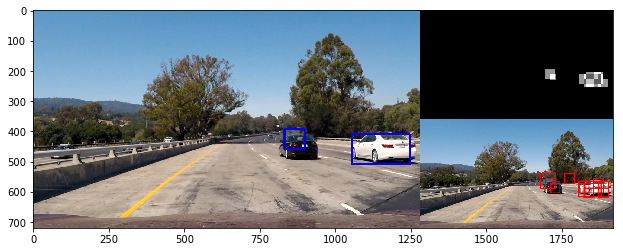

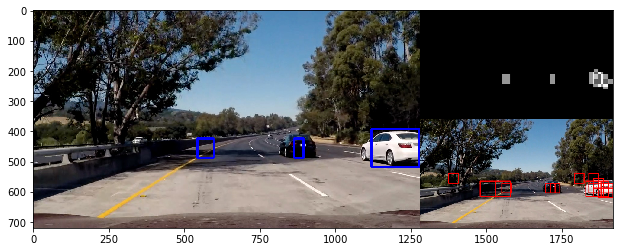

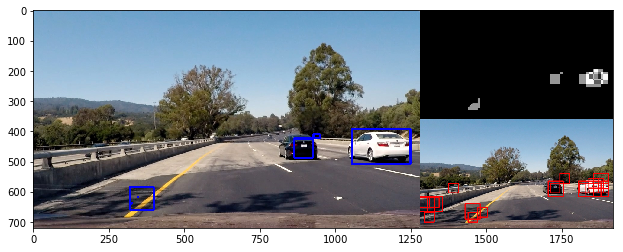

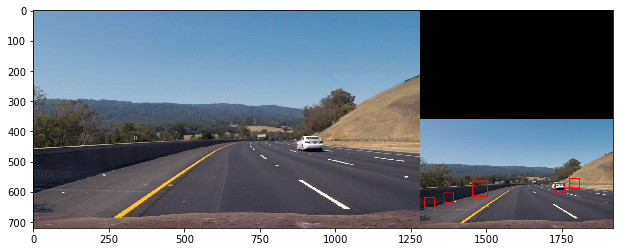

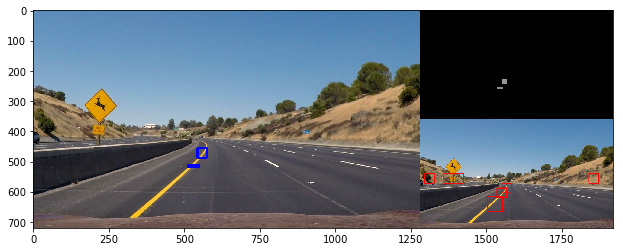

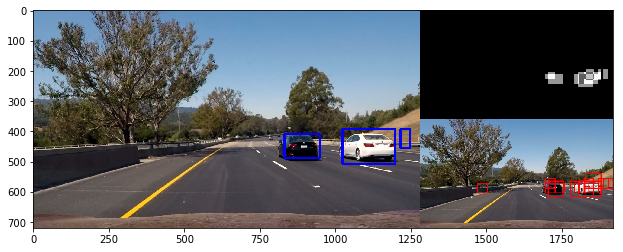

In [18]:
imgstrs = glob.glob('./test_images/*.jpg')

#plt.figure(figsize=(15,15))
i=0
for imgstr in imgstrs:
    img = cv2.cvtColor(cv2.imread(imgstr),cv2.COLOR_BGR2RGB)
    heat = (np.zeros_like(img[:,:,0])).astype(np.float)
    i=i+1
    #plt.subplot(6,1,i)
    
    #window_list = slide_window(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]]) 
    window_list1 = slide_window(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], xy_window=(64,64))
    window_list2 = slide_window(img, y_start_stop=[np.int(img.shape[0]/2), img.shape[0]], xy_window=(100,100))
    window_list = window_list1+window_list2
    hot_windows = search_windows(img, window_list, clf, X_scaler, hog_channel=0)
    heat = add_heat(heat,hot_windows)
    heatmap = apply_threshold(heat,1)
    labels = label(heatmap)
    
    img_act = draw_boxes(img, hot_windows, color=(255, 0, 0), thick=6)
    hmp_dsp = np.uint8(np.clip(heatmap*50,0,255))
    img_hmp = np.dstack((hmp_dsp,hmp_dsp,hmp_dsp))
    img_trk, bbox_centers = draw_labeled_bboxes(np.copy(img), labels)
    
    image1 = Image.fromarray(img_trk)
    image2 = Image.fromarray(img_hmp)
    image3 = Image.fromarray(img_act)
    
    image2=image2.resize((640,360),Image.ANTIALIAS)
    image3=image3.resize((640,360),Image.ANTIALIAS)
    
    result = Image.new('RGB',(image1.size[0]+image2.size[0],image1.size[1]))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(image1.size[0], 0))
    result.paste(im=image3, box=(image1.size[0], image2.size[1]))
    img_plt = np.array(result)
    
    plt.figure(figsize=(15,4))
    plt.imshow(img_plt)

# Apply search on video stream

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(img):
    global heat, frame_count, bbox_centers
    #img = cv2.cvtColor(cv2.imread(imgstr),cv2.COLOR_BGR2RGB)
    #heat = np.zeros_like(img[:,:,0])
    window_list = []
    
    if((frame_count % 10) == 0):
        window_list += (slide_window(img, x_start_stop=[250,1000], y_start_stop=[350,500], xy_window=(64,64)))
        window_list += (slide_window(img, x_start_stop=[250,1000], y_start_stop=[350,500], xy_window=(100,100)))
        window_list += (slide_window(img, x_start_stop=[0,350], y_start_stop=[350,720], xy_window=(64,64)))
        window_list += (slide_window(img, x_start_stop=[0,350], y_start_stop=[350,720], xy_window=(100,100)))
        window_list += (slide_window(img, x_start_stop=[900,1280], y_start_stop=[350,720], xy_window=(64,64)))
        window_list += (slide_window(img, x_start_stop=[900,1280], y_start_stop=[350,720], xy_window=(100,100)))
    for bbox_center in bbox_centers:
        x_search = np.clip([np.int(bbox_center[0]-80),np.int(bbox_center[0]+80)],0,img.shape[1])
        y_search = np.clip([np.int(bbox_center[1]-80),np.int(bbox_center[1]+80)],0,img.shape[0])
        window_list += (slide_window(img, x_start_stop=x_search, y_start_stop=y_search, xy_window=(64,64)))
        window_list += (slide_window(img, x_start_stop=x_search, y_start_stop=y_search, xy_window=(100,100)))
    hot_windows = search_windows(img, window_list, clf, X_scaler)
    heat = add_heat(heat,hot_windows)
    heatmap = apply_threshold(heat,6)
    labels = label(heatmap)
    
    img_act = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    hmp_dsp = np.uint8(np.clip(heatmap*50,0,255))
    img_hmp = np.dstack((hmp_dsp,hmp_dsp,hmp_dsp))
    img_trk, bbox_centers = draw_labeled_bboxes(np.copy(img), labels)
    
    image1 = Image.fromarray(img_trk)
    image2 = Image.fromarray(img_hmp)
    image3 = Image.fromarray(img_act)
    
    image2=image2.resize((640,360),Image.ANTIALIAS)
    image3=image3.resize((640,360),Image.ANTIALIAS)
    
    result = Image.new('RGB',(image1.size[0]+image2.size[0],image1.size[1]))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(image1.size[0], 0))
    result.paste(im=image3, box=(image1.size[0], image2.size[1]))
    img_plt = np.array(result)
    
    frame_count += 1
    
    return img_plt

In [21]:
video_output = './test_videos_output/project_video.mp4'
video_input = VideoFileClip("./test_videos_input/project_video.mp4")
global heat, frame_count
frame_count = 0
heat = np.zeros(shape=(720,1280,1))
clip = video_input.fl_image(process_image)#.subclip(0,5) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:46<00:00,  5.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 10min 37s, sys: 3.09 s, total: 10min 40s
Wall time: 3min 46s


## ---------------------